In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/drive/My Drive/deep learning HW3/TSLA.csv'
df = pd.read_csv(file_path)

#挂载了Drive之后，您可以像访问本地文件系统一样访问Google Drive中的文件

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [ ]:
df.shape

(1259, 7)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [ ]:
missing_value=df.isnull().sum()
print(missing_value)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


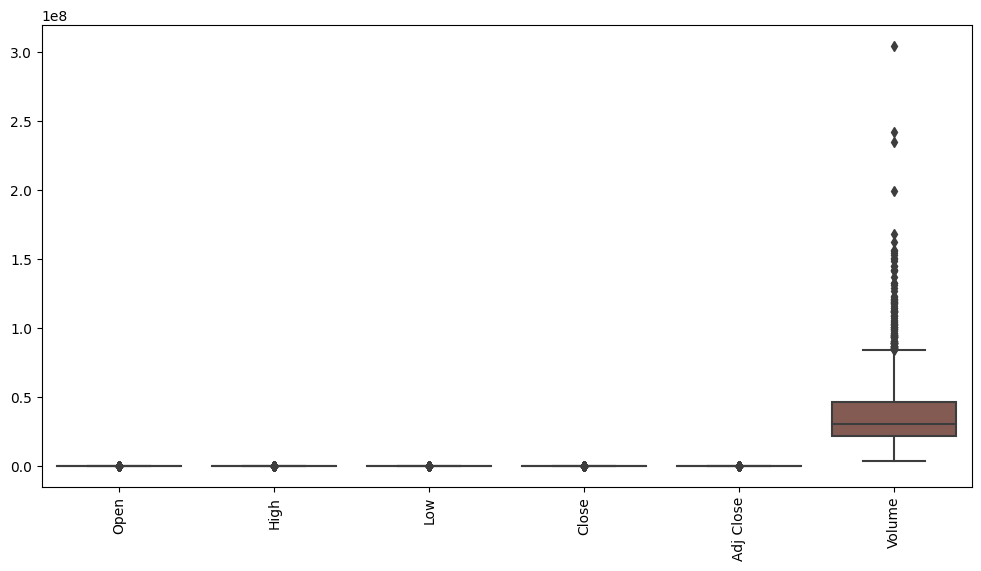

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

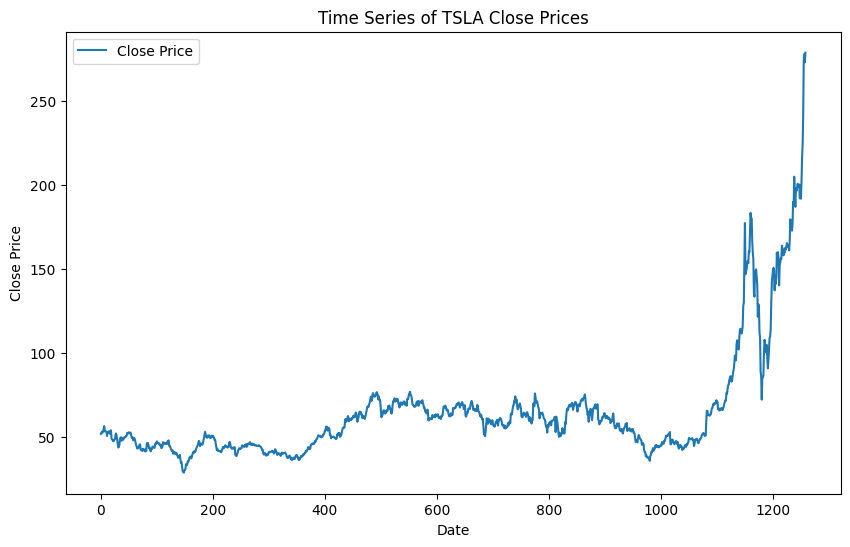

In [ ]:
##画时间序列图

plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Time Series of TSLA Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import matplotlib.dates as mdates


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
data = df.filter(['Close'])
data

,Close
0,51.830002
1,52.431999
2,53.130001
3,52.627998
4,53.335999
...,...
1254,241.731995
1255,274.316010
1256,277.971985
1257,273.175995


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step):
    x_data, y_data = [], []
    for i in range(time_step, len(dataset)):
        x_data.append(dataset[i-time_step:i, 0])
        y_data.append(dataset[i, 0])
    return np.array(x_data), np.array(y_data)

Epoch 1/100
13/13 [==============================] - 6s 90ms/step - loss: 0.2930 - val_loss: 0.2893
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.2178 - val_loss: 0.1959
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.1331 - val_loss: 0.0942
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0544 - val_loss: 0.0231
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0238 - val_loss: 0.0135
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0193 - val_loss: 0.0123
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0175 - val_loss: 0.0101
Epoch 9/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0158 - val_loss: 0.0087
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0076
Ep

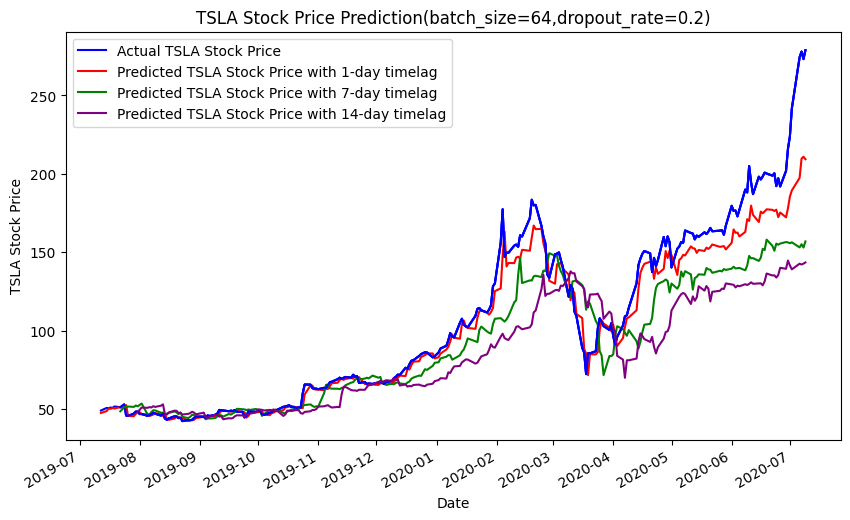

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# 定义分割数据的比例
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# Split the data into training and test sets based on the index
train_data = df[:split_index]
test_data = df[split_index:]

# 定义一个创建lagged features的函数
def create_lagged_features(data, lags):
    lagged_data = pd.DataFrame(index=data.index)
    for lag in lags:
        lagged_data[f'lag_{lag}'] = data['Close'].shift(lag)
    return lagged_data

# 定义LSTM模型结构
def build_lstm_model(input_shape, neurons=50, dropout_rate=0.2, optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model

# 定义lags
lags = [1, 7, 14]
predicted_stock_prices = []
dates_list = []  # 为每次迭代存储相应的日期
y_tests = []  # 存储每次迭代的y_test


# 循环为每个lag训练模型并进行预测
for lag in lags:
    train_lagged = create_lagged_features(train_data, [lag]).dropna()
    test_lagged = create_lagged_features(test_data, [lag]).dropna()

    y_train = train_data.loc[train_lagged.index]['Close']
    y_test = test_data.loc[test_lagged.index]['Close']

    y_tests.append(y_test)  # 添加当前迭代的y_test到列表

    # Initialize and fit the scalers for each iteration
    X_scaler = MinMaxScaler()
    X_train_normalized = X_scaler.fit_transform(train_lagged)

    Y_scaler = MinMaxScaler()
    y_train_normalized = Y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    X_test_normalized = X_scaler.transform(test_lagged)
    y_test_normalized = Y_scaler.transform(y_test.values.reshape(-1, 1))

    # Reshape data to 3D for LSTM
    X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
    X_test_reshaped = np.reshape(X_test_normalized, (X_test_normalized.shape[0], 1, X_test_normalized.shape[1]))

    lstm_model = build_lstm_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    lstm_model.fit(X_train_reshaped, y_train_normalized, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

    predicted_stock_prices_normalized = lstm_model.predict(X_test_reshaped)
    predicted_stock_prices.append(Y_scaler.inverse_transform(predicted_stock_prices_normalized))
    dates_list.append(test_data.loc[test_lagged.index]['Date'].values)

# ...[可视化的代码]


# 可视化预测结果
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'purple']

for i, lag in enumerate(lags):
    plt.plot(dates_list[i], y_tests[i].values, color='blue', label='Actual TSLA Stock Price' if i==0 else "")  # 使用y_tests[i]代替y_test
    plt.plot(dates_list[i], predicted_stock_prices[i], color=colors[i], label=f'Predicted TSLA Stock Price with {lag}-day timelag')

# 设置x轴为日期格式，并设置间隔为每月
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # 设置主要的间隔为每月
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 设置日期格式
plt.gcf().autofmt_xdate()  # 旋转x轴的标签以增加可读性

plt.title('TSLA Stock Price Prediction(batch_size=64,dropout_rate=0.2)')
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()



Epoch 1/100
13/13 [==============================] - 9s 106ms/step - loss: 0.3022 - val_loss: 0.3034
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.2329 - val_loss: 0.2203
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.1575 - val_loss: 0.1236
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0789 - val_loss: 0.0407
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0324 - val_loss: 0.0139
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0308 - val_loss: 0.0128
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0285 - val_loss: 0.0141
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0252 - val_loss: 0.0129
Epoch 9/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0246 - val_loss: 0.0115
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0223 - val_loss: 0.0093
Ep

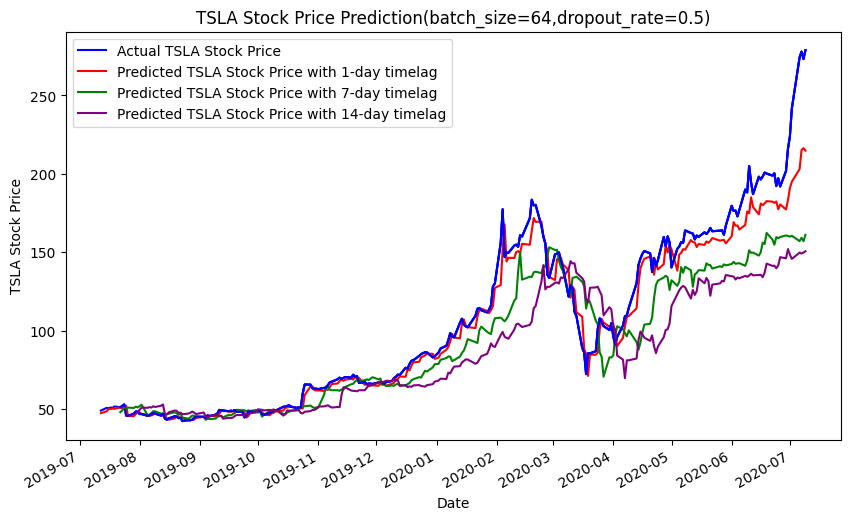

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

# 假设df已经定义，并且包含Close和Date列
# 如果没有，请确保导入或定义适当的数据。

# 定义分割数据的比例
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# Split the data into training and test sets based on the index
train_data = df[:split_index]
test_data = df[split_index:]

# 定义一个创建lagged features的函数
def create_lagged_features(data, lags):
    lagged_data = pd.DataFrame(index=data.index)
    for lag in lags:
        lagged_data[f'lag_{lag}'] = data['Close'].shift(lag)
    return lagged_data

# 定义LSTM模型结构
def build_lstm_model(input_shape, neurons=50, dropout_rate=0.5, optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model

# 定义lags
lags = [1, 7, 14]
predicted_stock_prices = []
dates_list = []
y_tests = []

for lag in lags:
    train_lagged = create_lagged_features(train_data, [lag]).dropna()
    test_lagged = create_lagged_features(test_data, [lag]).dropna()

    y_train = train_data.loc[train_lagged.index]['Close']
    y_test = test_data.loc[test_lagged.index]['Close']

    y_tests.append(y_test)

    # Normalize the data
    X_scaler = MinMaxScaler()
    X_train_normalized = X_scaler.fit_transform(train_lagged)

    Y_scaler = MinMaxScaler()
    y_train_normalized = Y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    X_test_normalized = X_scaler.transform(test_lagged)

    X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
    X_test_reshaped = np.reshape(X_test_normalized, (X_test_normalized.shape[0], 1, X_test_normalized.shape[1]))

    lstm_model = build_lstm_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    lstm_model.fit(X_train_reshaped, y_train_normalized, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

    predicted_stock_prices_normalized = lstm_model.predict(X_test_reshaped)
    predicted_stock_prices.append(Y_scaler.inverse_transform(predicted_stock_prices_normalized))
    dates_list.append(test_data.loc[test_lagged.index]['Date'].values)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'purple']

for i, lag in enumerate(lags):
    plt.plot(dates_list[i], y_tests[i].values, color='blue', label='Actual TSLA Stock Price' if i == 0 else "")
    plt.plot(dates_list[i], predicted_stock_prices[i], color=colors[i], label=f'Predicted TSLA Stock Price with {lag}-day timelag')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('TSLA Stock Price Prediction(batch_size=64,dropout_rate=0.5)')
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/drive/My Drive/deep learning HW3/TSLA.csv'
df = pd.read_csv(file_path)



Mounted at /content/drive


Epoch 1/50
28/28 [==============================] - 5s 47ms/step - loss: 0.0485 - val_loss: 0.0198
Epoch 2/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0186 - val_loss: 0.0127
Epoch 3/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0185 - val_loss: 0.0153
Epoch 4/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0176 - val_loss: 0.0130
Epoch 5/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0175 - val_loss: 0.0183
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0117
Epoch 7/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 8/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 9/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 11/50
28/28 

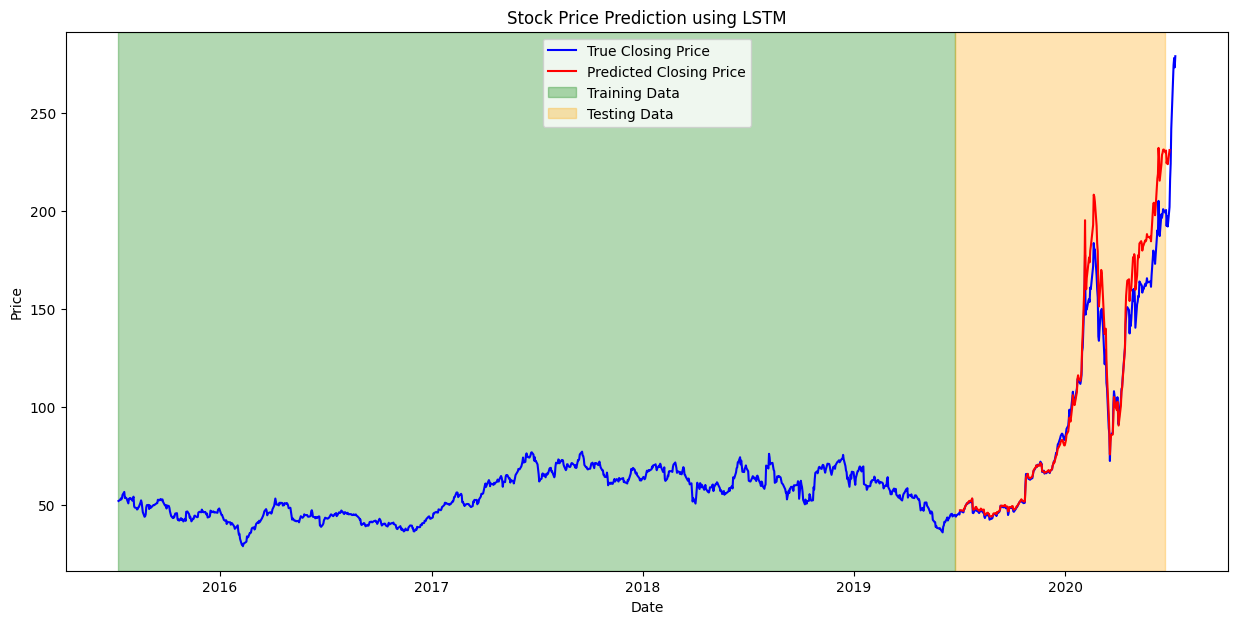

RMSE: 13.946047308416064
MAPE: 6.550110162495964%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/My Drive/deep learning HW3/TSLA.csv'
data = pd.read_csv(file_path)


# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])


# Extract the 'Close' column as the feature to be used for predictions
close_prices = data['Close'].values.reshape(-1, 1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the close prices
scaled_close_prices = scaler.fit_transform(close_prices)

# Function to create sequences of 7 days for LSTM input and the next 7 days for output
def create_sequences(data, sequence_length=7):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length * 2 + 1):
        x_sequence = data[i:(i + sequence_length)]
        y_sequence = data[(i + sequence_length):(i + sequence_length * 2)]
        xs.append(x_sequence)
        ys.append(y_sequence)
    return np.array(xs), np.array(ys)

# Create sequences of 7 days
X, y = create_sequences(scaled_close_prices)

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model (2 hidden layer)
model = Sequential()
model.add(LSTM(units=260, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=260, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=7))  # Predicting the next 7 days



# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 7))

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_inverse[:, 0], predictions_inverse[:, 0]))
mape = np.mean(np.abs((y_test_inverse[:, 0] - predictions_inverse[:, 0]) / y_test_inverse[:, 0])) * 100

# Extract the dates from the original dataframe for plotting
dates = data['Date'].values

# Prepare the dates for the predicted values
# The predicted dates will start after the last training date
predicted_dates = dates[len(X_train) + 7 - 1:len(X_train) + len(predictions_inverse) + 7 - 1]

# Plotting
plt.figure(figsize=(15,7))

# Plot all true values
plt.plot(dates, data['Close'], label='True Closing Price', color='blue')

# Plot predicted values
plt.plot(predicted_dates, predictions_inverse[:, 0], label='Predicted Closing Price', color='red')

# Highlight the training part
plt.axvspan(dates[0], dates[len(X_train)], color='green', alpha=0.3, label='Training Data')

# Highlight the testing part
plt.axvspan(dates[len(X_train)], dates[len(X_train) + len(X_test)], color='orange', alpha=0.3, label='Testing Data')

# Add title and labels
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show the plot
plt.show()

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")








Epoch 1/50
28/28 [==============================] - 8s 32ms/step - loss: 0.0992 - val_loss: 0.0364
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0435 - val_loss: 0.0297
Epoch 3/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0377 - val_loss: 0.0346
Epoch 4/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0358 - val_loss: 0.0268
Epoch 5/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0345 - val_loss: 0.0281
Epoch 6/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0237
Epoch 7/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0302 - val_loss: 0.0266
Epoch 8/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0299 - val_loss: 0.0237
Epoch 9/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0194
Epoch 10/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0244
Epoch 11/50
28/28 

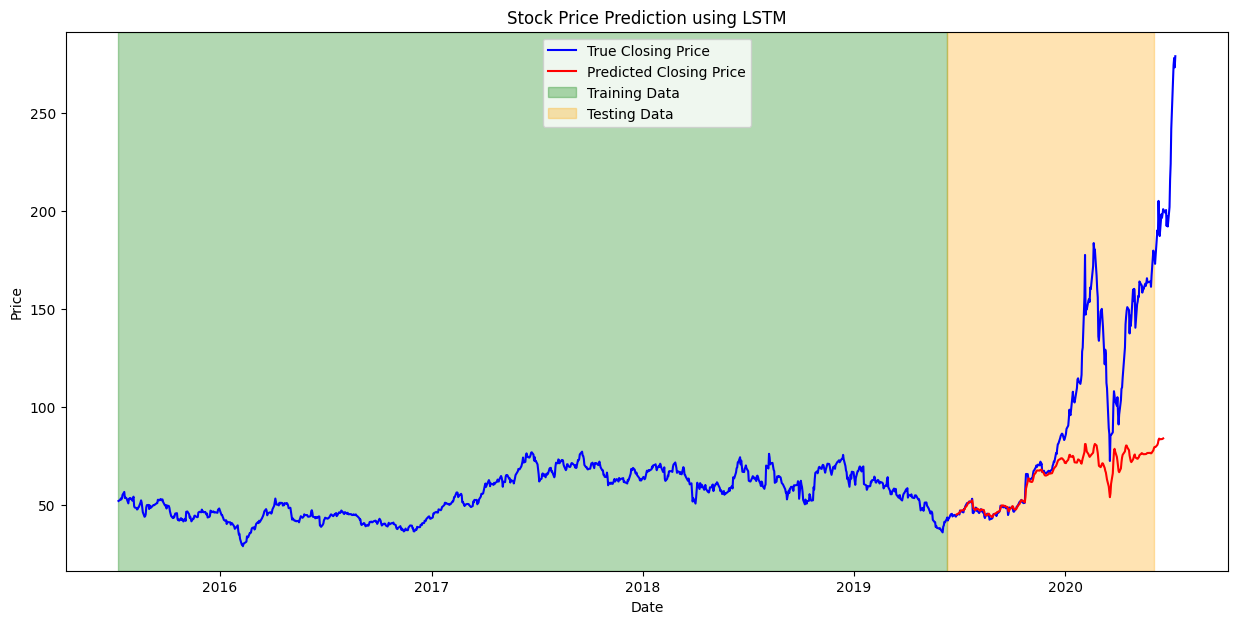

RMSE: 49.86460826472332
MAPE: 23.22692155135534%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/My Drive/deep learning HW3/TSLA.csv'
data = pd.read_csv(file_path)


# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])


# Extract the 'Close' column as the feature to be used for predictions
close_prices = data['Close'].values.reshape(-1, 1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the close prices
scaled_close_prices = scaler.fit_transform(close_prices)

# Function to create sequences of 14 days for LSTM input and the next 14 days for output
def create_sequences(data, sequence_length=14):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length * 2 + 1):
        x_sequence = data[i:(i + sequence_length)]
        y_sequence = data[(i + sequence_length):(i + sequence_length * 2)]
        xs.append(x_sequence)
        ys.append(y_sequence)
    return np.array(xs), np.array(ys)

# Create sequences of 14 days
X, y = create_sequences(scaled_close_prices)

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model with 2 layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=14))  # Predicting the next 14 days






# #Define the LSTM model with 6 layers
# model = Sequential()
# model.add(LSTM(units=260, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.5))
# model.add(LSTM(units=260, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(units=260, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(units=260, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(units=25))  # An intermediate dense layer
# model.add(Dense(units=14))  # Final output layer predicting the next 14 days




# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 14))

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_inverse[:, 0], predictions_inverse[:, 0]))
mape = np.mean(np.abs((y_test_inverse[:, 0] - predictions_inverse[:, 0]) / y_test_inverse[:, 0])) * 100

# Extract the dates from the original dataframe for plotting
dates = data['Date'].values

# Prepare the dates for the predicted values
# The predicted dates will start after the last training date
predicted_dates = dates[len(X_train) + 14 - 1:len(X_train) + len(predictions_inverse) + 14 - 1]

# Plotting
plt.figure(figsize=(15,7))

# Plot all true values
plt.plot(dates, data['Close'], label='True Closing Price', color='blue')

# Plot predicted values
plt.plot(predicted_dates, predictions_inverse[:, 0], label='Predicted Closing Price', color='red')

# Highlight the training part
plt.axvspan(dates[0], dates[len(X_train)], color='green', alpha=0.3, label='Training Data')

# Highlight the testing part
plt.axvspan(dates[len(X_train)], dates[len(X_train) + len(X_test)], color='orange', alpha=0.3, label='Testing Data')

# Add title and labels
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show the plot
plt.show()

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")








Epoch 1/50
29/29 [==============================] - 4s 30ms/step - loss: 0.0962 - val_loss: 0.0102
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0026
Epoch 3/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 5/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 6/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 8/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 9/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 10/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 11/50
29/29 

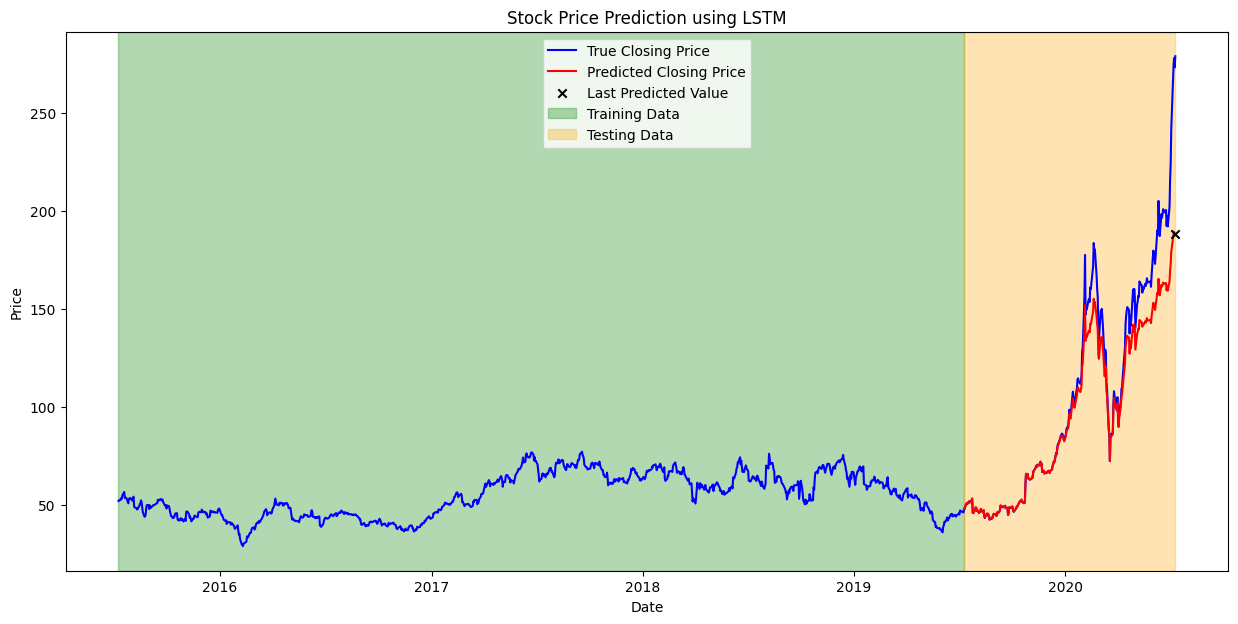

RMSE: 19.083926770501154
MAPE: 6.885508843669322%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/My Drive/deep learning HW3/TSLA.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract the 'Close' column as the feature to be used for predictions
close_prices = data['Close'].values.reshape(-1, 1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the close prices
scaled_close_prices = scaler.fit_transform(close_prices)

# Function to create sequences of 1 day for LSTM input and 1 day for output
def create_sequences(data, sequence_length=1):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x_sequence = data[i:(i + sequence_length)]
        y_sequence = data[i + sequence_length:i + sequence_length + 1]
        xs.append(x_sequence)
        ys.append(y_sequence)
    return np.array(xs), np.array(ys)

# Create sequences of 1 day
X, y = create_sequences(scaled_close_prices)

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model with 2 layers
model = Sequential()
model.add(LSTM(units=260, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=260))
model.add(Dropout(0.5))
model.add(Dense(units=1))  # Predicting the next day

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to their original scale
# Inverse transform the predictions and actuals to their original scale
# Ensure that we only inverse transform the last step of each sequence
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100

# Extract the dates from the original dataframe for plotting
dates = data['Date'].values

# Prepare the dates for the predicted values
# The predicted dates will start after the last training date
predicted_dates = dates[len(X_train):len(X_train) + len(predictions_inverse)]

# Plotting
plt.figure(figsize=(15,7))

# Plot all true values
plt.plot(dates, data['Close'], label='True Closing Price', color='blue')

# Plot predicted values
plt.plot(predicted_dates, predictions_inverse, label='Predicted Closing Price', color='red')

# Special symbol for the last predicted value
plt.scatter(predicted_dates[-1], predictions_inverse[-1], marker='x', color='black', label='Last Predicted Value', zorder=5)

# Highlight the training part
plt.axvspan(dates[0], dates[len(X_train)], color='green', alpha=0.3, label='Training Data')

# Highlight the testing part
plt.axvspan(dates[len(X_train)], dates[-1], color='orange', alpha=0.3, label='Testing Data')

# Add title and labels
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show the plot
plt.show()

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
